This notebook describes an example of the interpolation of altimetry data.<br>
The reading/writing of input files is done through specific classes defined in `pydiva2d.py`.

In [29]:
import os
import logging
import shutil
import subprocess
import numpy as np
import importlib
import sys
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap

Add package directory to Python path:

In [2]:
sys.path.insert(0, "../")

Import the `pydiva2d` module

In [3]:
import pydiva2d

# Setup 

## Logging configuration

The *logging* is already configured in `pydiva2d`.<br>
Replace 'DEBUG' by 'INFO', 'WARNING' or 'ERROR'.

In [4]:
logger = logging.getLogger('divaAltimetry')
logger.setLevel(logging.DEBUG)

## Files and directories

Set the path to the Diva installation you want to work with.

In [5]:
divadir = "/home/ctroupin/Software/DIVA/DIVA-diva-4.7.1"

In [6]:
coastfile = "/home/ctroupin/Projects/Altimetry-Interpolation/diva/coast.cont"
datafile = "/home/ctroupin/Projects/Altimetry-Interpolation/data/ADT_20140322_20140411.dat"
paramfile = "/home/ctroupin/Projects/Altimetry-Interpolation/diva/param.par"

## Matplotlib options

In [7]:
rcParams.update({'font.size': 16, 'figure.dpi': 300, 'savefig.bbox': 'tight'})
# rcParams.keys

### Projection

In [30]:
m = Basemap(projection='merc',
            llcrnrlon=-6., llcrnrlat=30.,
            urcrnrlon=40., urcrnrlat=48.,
            lat_ts=39., resolution='i')

## Directories

Create variables storing the Diva directories.

In [8]:
DivaDirs = pydiva2d.DivaDirectories(divadir)

Create variables storing the Diva input and output files.

In [9]:
DivaFiles = pydiva2d.Diva2Dfiles(DivaDirs.diva2d)

# Prepare the input files

## Contour

We read it from an existing file created using the local topography.

In [10]:
contour2D = pydiva2d.Diva2DContours()
contour2D.read_from(coastfile)

and write its content to the corresponding file defined in the **DivaFile** object:

In [11]:
contour2D.write_to(DivaFiles.contour)

## Data

We also read it from an existing file:

In [12]:
data2D = pydiva2d.Diva2DData()
data2D.read_from(datafile)
data2D.count_data

18376

and we write the values to the specified file:

In [13]:
data2D.write_to(DivaFiles.data)

## Parameters

Read from existing `param.par` file:

In [14]:
parameters2D = pydiva2d.Diva2DParameters()
parameters2D.read_from(paramfile)
parameters2D.describe()

Correlation length: 2.0
icoordchange: 2
ispec: 11
ireg: 2
Domain: x-axis: from -5.5 to 37.0 with 426 steps of 0.1
Domain: y-axis: from 30.0 to 46.0 with 161 steps of 0.1
Exclusion value: -99.0
Signal-to-noise ratio: 0.5
Variance of the background field: 1.0


and we write them into a file:

In [15]:
parameters2D.write_to(DivaFiles.parameter)

## List of extra points

In this example we don't require any additional points for the analysis.

# Run Diva

Now that the input files have been created we can perform a Diva analysis.

## Mesh generation

Call the script `divamesh`.

In [16]:
logger.info("Starting generation of the finite-element mesh")
subprocess.Popen("./divamesh", cwd=DivaDirs.diva2d, shell=True)
logger.info("Finished generation of the finite-element mesh")

## Run the diva calculation

Call the script `divacalc`.

In [17]:
logger.info("Starting computation of the gridded field")
subprocess.Popen("./divacalc", cwd=DivaDirs.diva2d, shell=True)
logger.info("Finished computation of the gridded field")

# Time for some plots

We import a few more modules to plot the input files content and the results.<br>
The last line asks for the plot to be done within the notebook, not as external window.

In [18]:
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline

## Input files

Let's display:
* the observations (colored dots), 
* the output grid,
* and the contours.

By default, each contour is represented in a different color.<br>
In this example the data files contains 20 days of observations, this is why the spatial coverage seems very good.

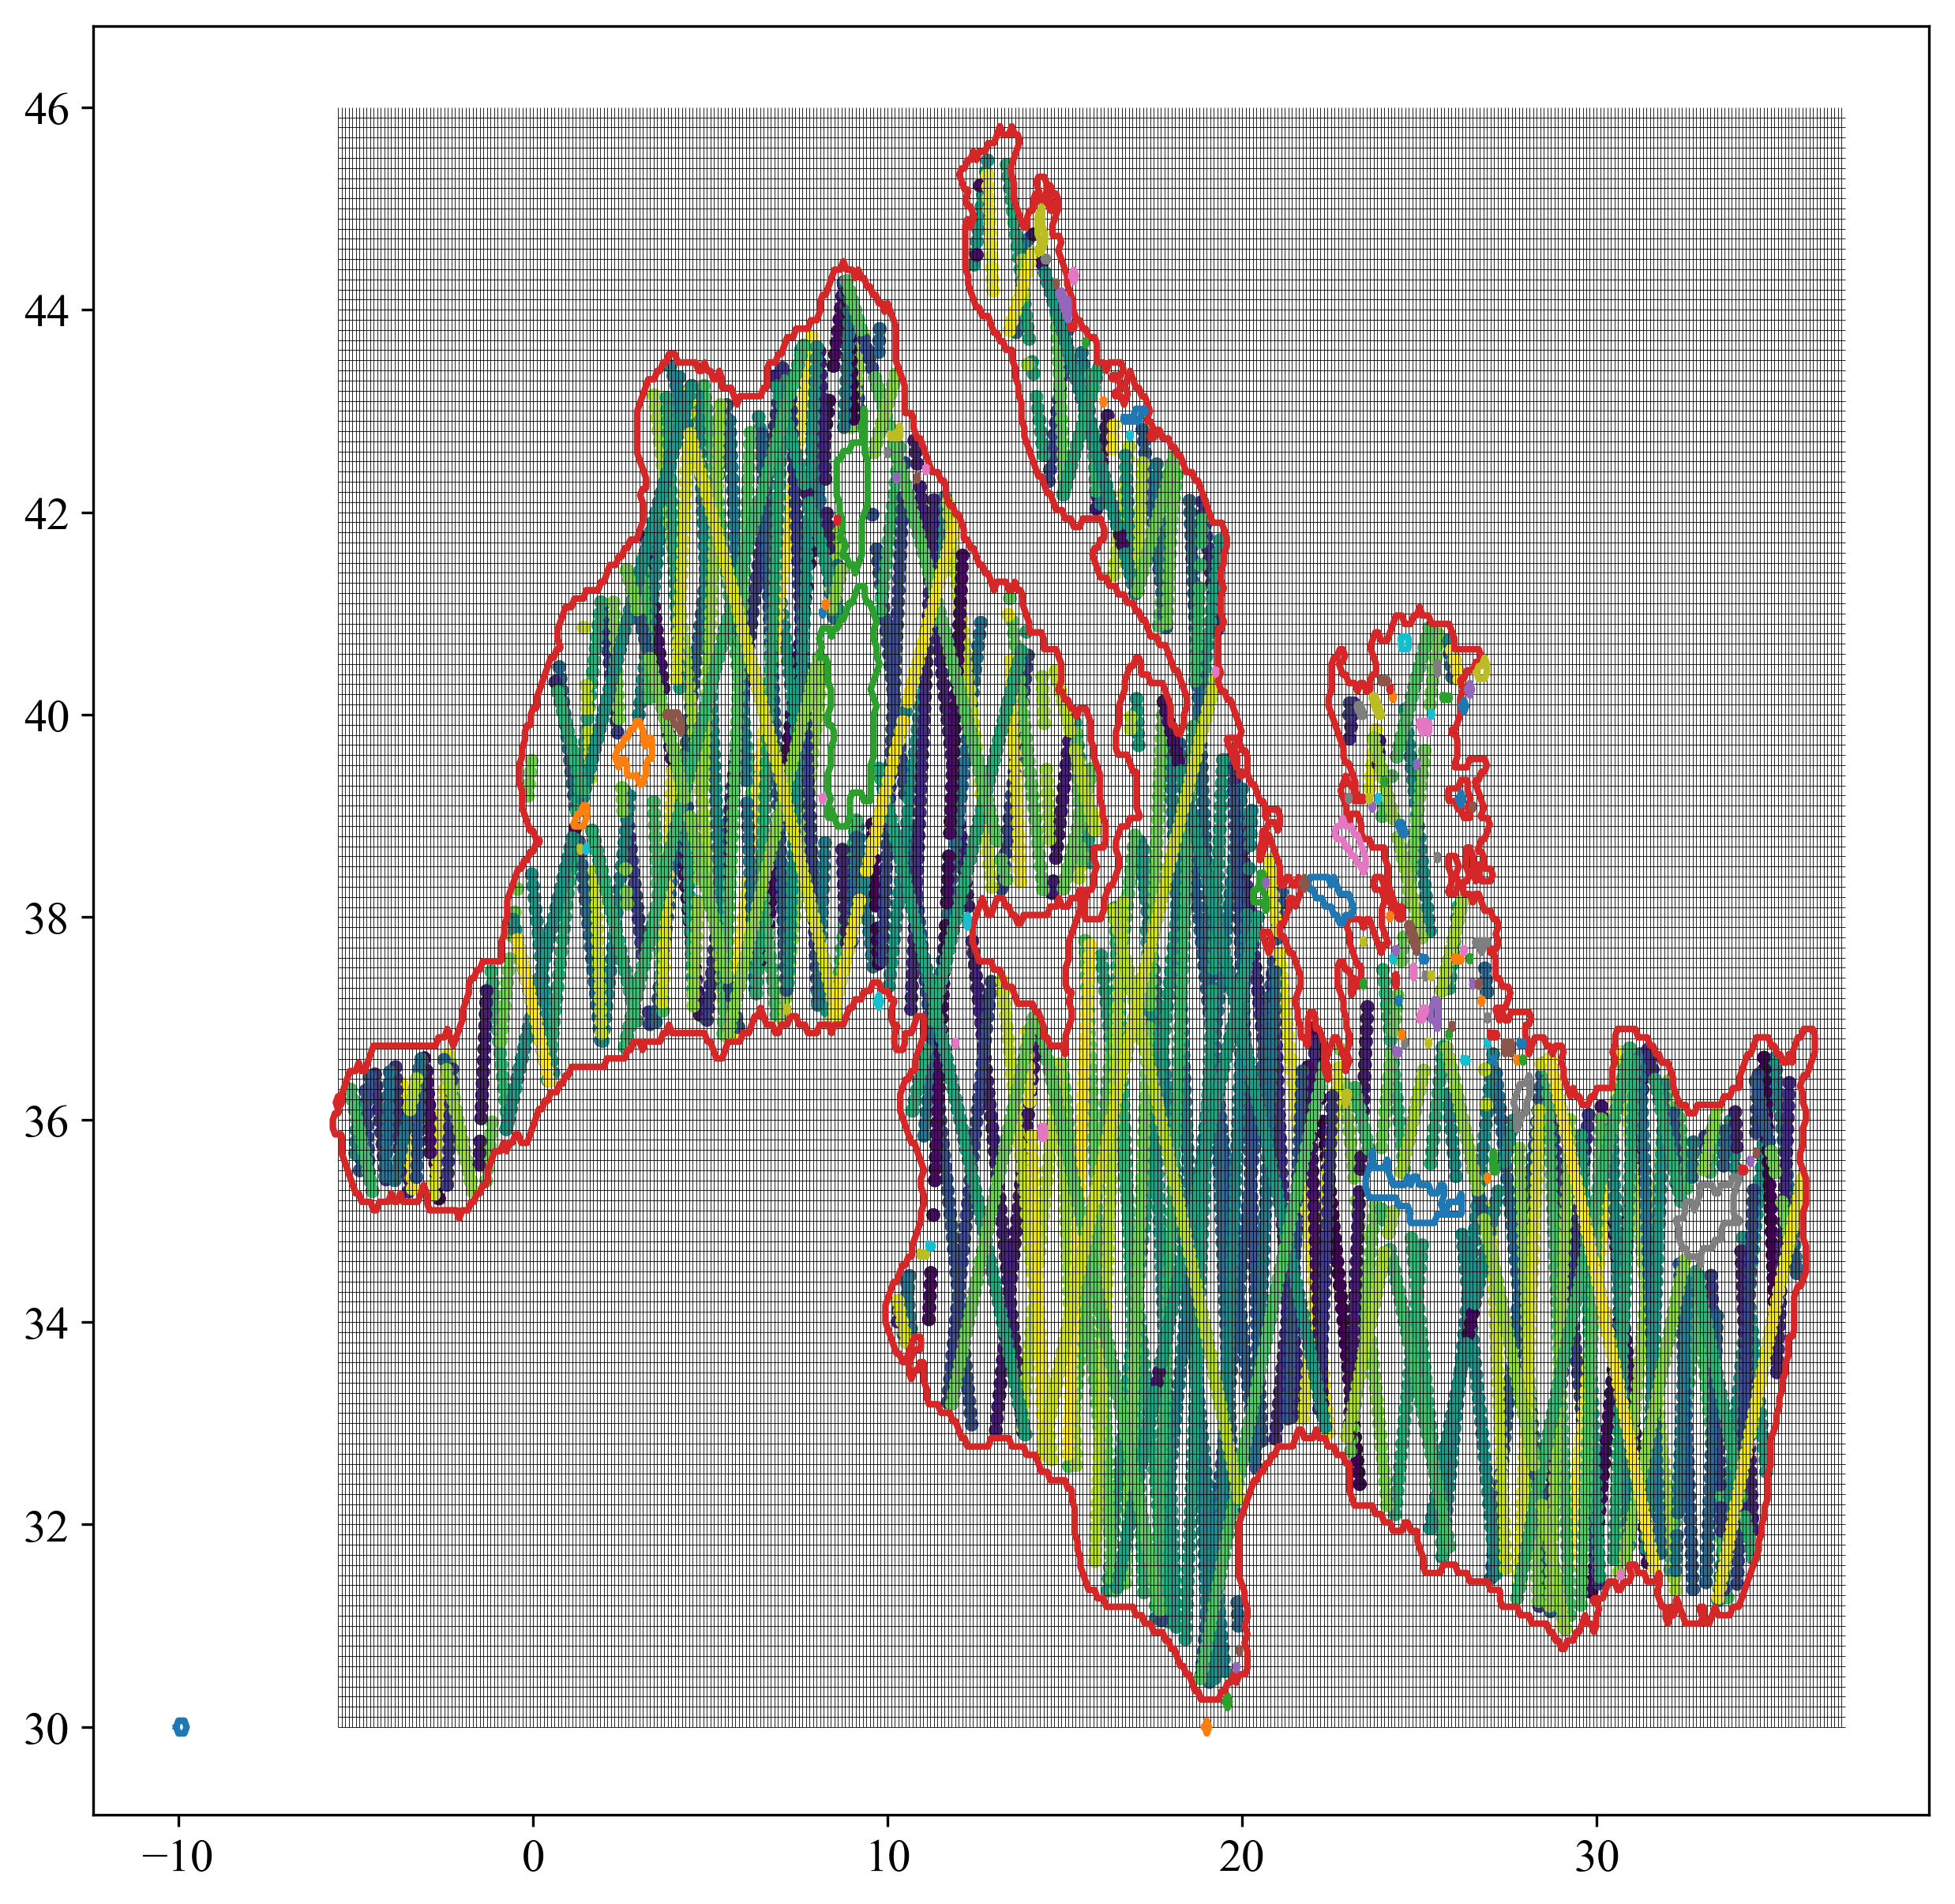

In [19]:
fig = plt.figure(figsize=(10, 10))
contour2D.add_to_plot(linewidth=2)
data2D.add_to_plot(s=10)
parameters2D.plot_outputgrid()

## Results 

Let's represent the gridded field obtained by the interpolation:

In [23]:
results2D.add_to_plot?

/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


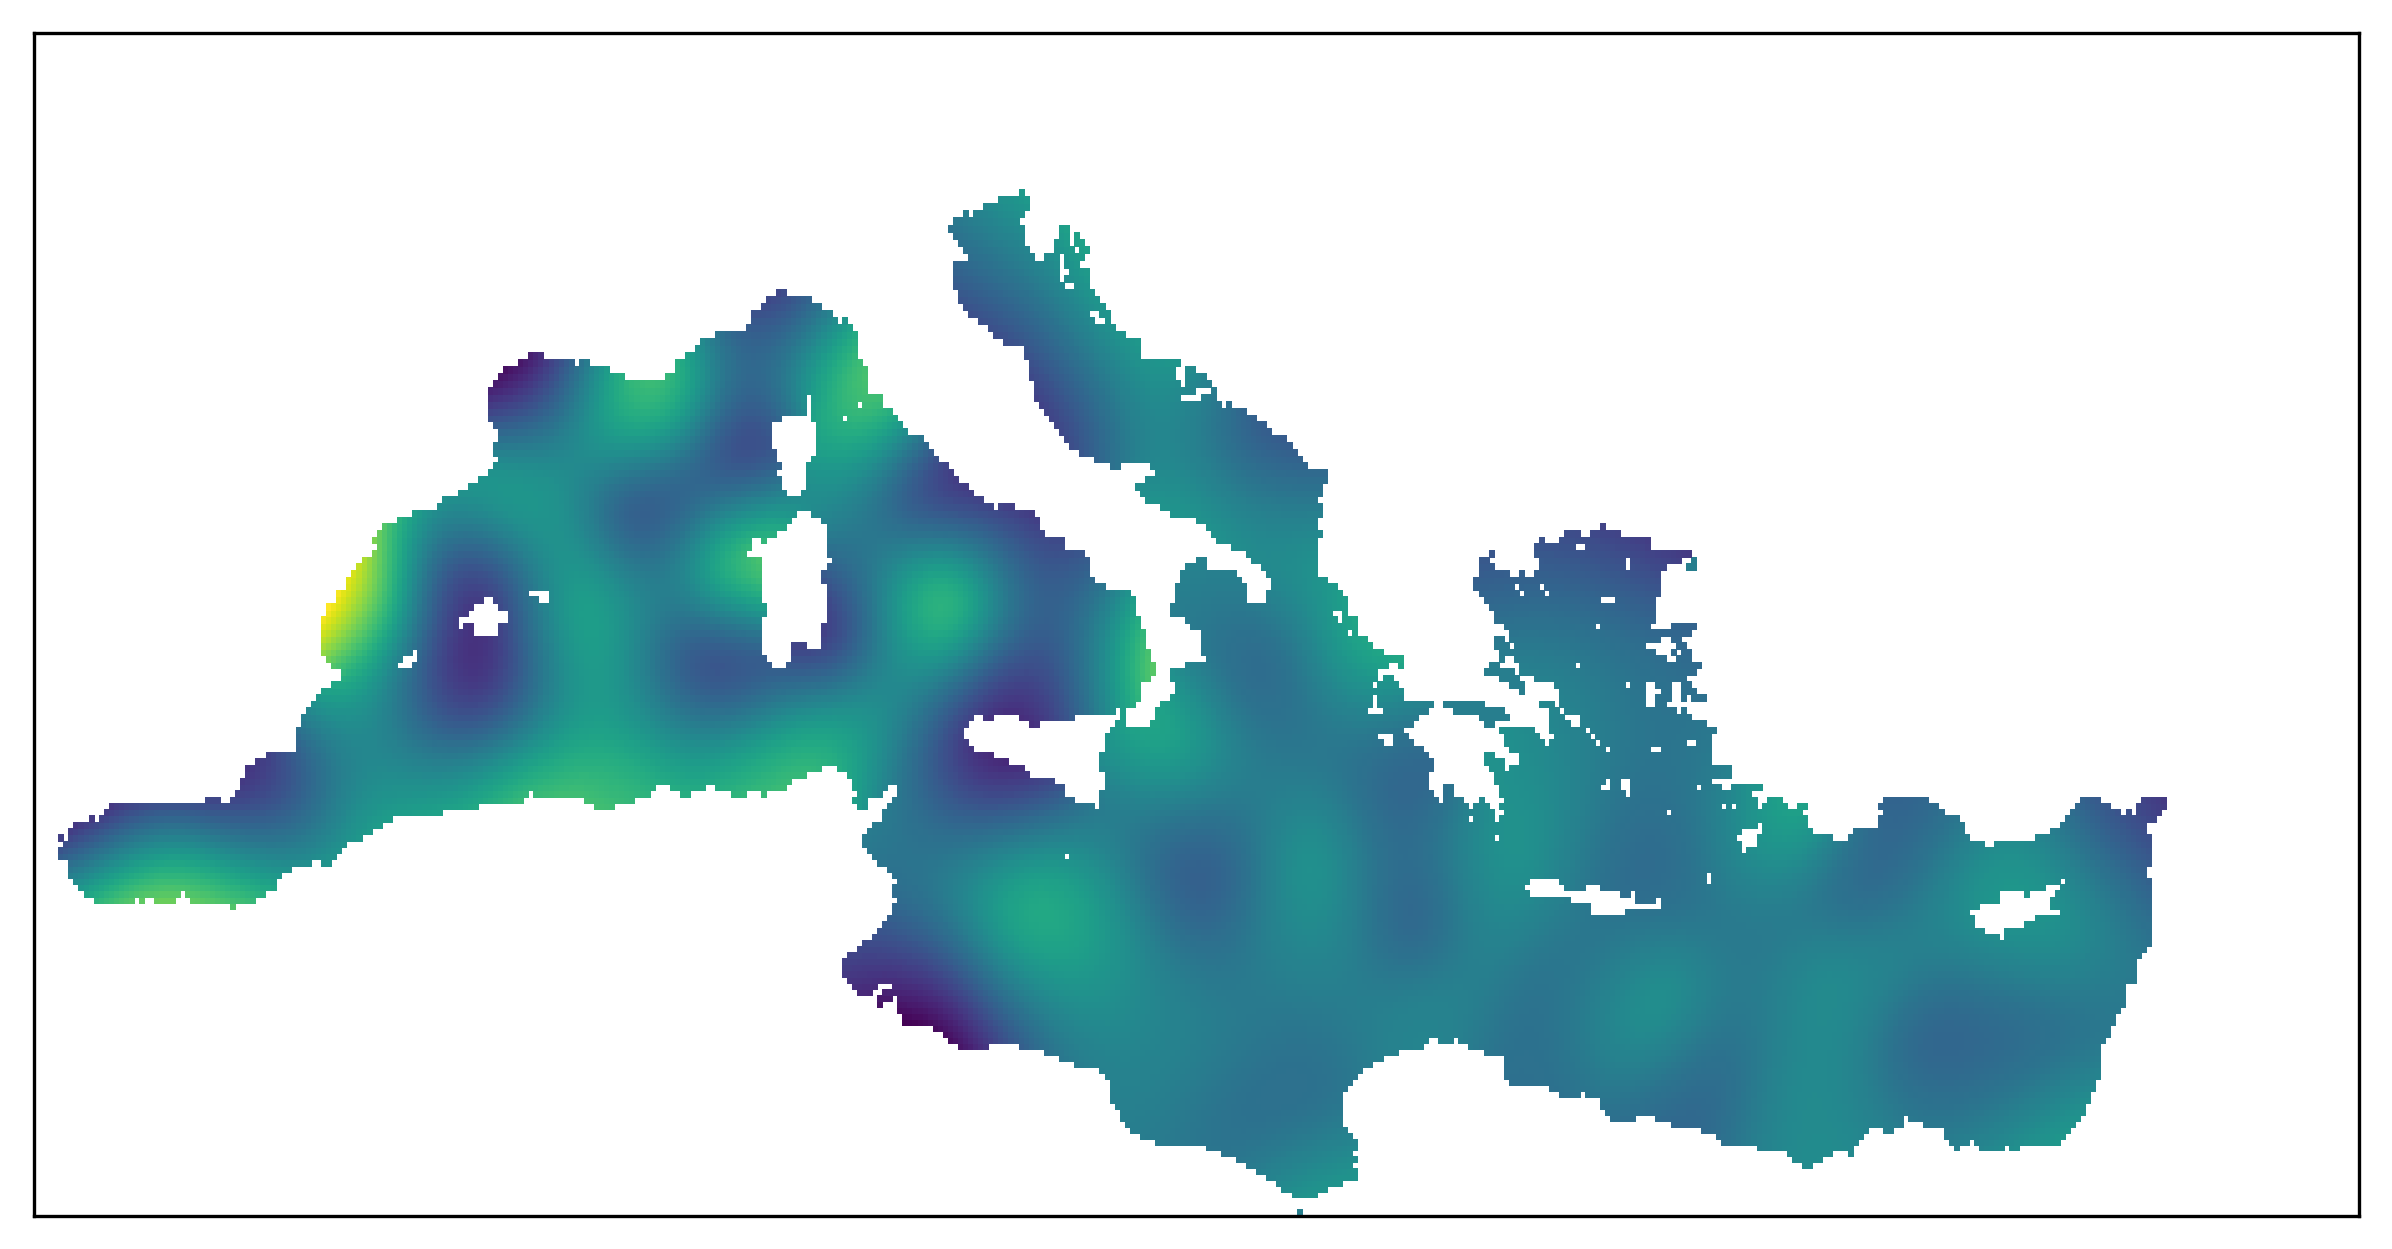

In [31]:
fig = plt.figure(figsize=(10, 10))
results2D = pydiva2d.Diva2DResults()
results2D.read_from(DivaFiles.result)
results2D.add_to_plot('analysis', m)
#data2D.add_to_plot(cmap=plt.cm.viridis, s=.2)

The error field is represented using a similar command:

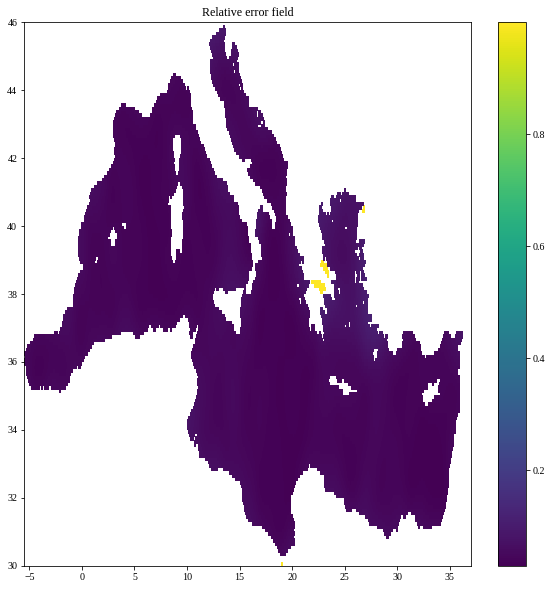

In [57]:
fig = plt.figure(figsize=(10, 10))
error2D = results2D.add_to_plot('error')
#data2D.add_positions_to_plot(s=2)
plt.colorbar(error2D)
plt.title('Relative error field')

With the select set of parameters, the error is low in the largest part of the basin, the exception is in sub-regions in the vicinity of Greece.

## Finite-element mesh

It is also interesting to display the finite-element mesh that covers our domain of interest.

In [63]:
mesh2D = pydiva2d.Diva2DMesh()
mesh2D.read_from(DivaFiles.mesh, DivaFiles.meshtopo)

With the `describe` method we obtain details about the mesh:

In [65]:
mesh2D.describe()

Number of nodes: 5477
Number of interfaces: 12612
Number of elements: 7042


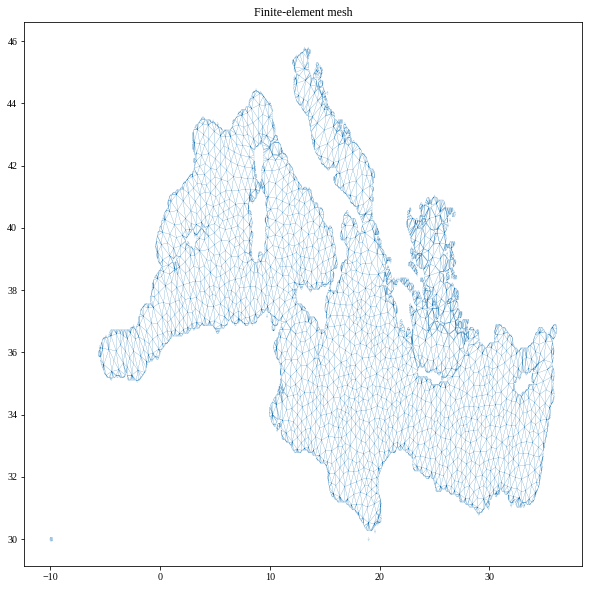

In [66]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
mesh2D.add_to_plot(lw=0.1)
plt.title('Finite-element mesh')